# <a id='2'>Prepare for data analysis</a>  


## Load packages


In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

## Load data   

Let's check what data files are available.

In [2]:
PATH="../../data/"

Let's load the train and test data files.

In [3]:

train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

# <a id='3'>Data exploration</a>  

## <a id='31'>Check the data</a>  

Let's check the train and test set.

In [4]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

Both train and test data have 200,000 entries and 202, respectivelly 201 columns. 

Let's glimpse train and test dataset.

In [5]:

#features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
#for feature in features:
    #train_df[feature] = np.power(train_df[feature],2)
    #test_df[feature] = np.power(test_df[feature],2)
    #train_df['l_'+feature] = np.log(train_df[feature])
    #test_df['l_'+feature] = np.log(test_df[feature])
    #train_df['p2_'+feature] = np.power(train_df[feature], 2)
    #test_df['p2_'+feature] = np.power(test_df[feature], 2)
    #train_df['r2_'+feature] = np.round(train_df[feature], 2)
    #test_df['r2_'+feature] = np.round(test_df[feature], 2)
    #train_df['r1_'+feature] = np.round(train_df[feature], 1)
    #test_df['r1_'+feature] = np.round(test_df[feature], 1)


Let's check how many features we have now.

In [6]:
print('Train and test columns: {} {}'.format(len(train_df.columns), len(test_df.columns)))

Train and test columns: 202 201


# <a id='5'>Model</a>  

From the train columns list, we drop the ID and target to form the features list.

In [7]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

We define the hyperparameters for the model.

In [8]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [9]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 20.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

We run the model.

In [10]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    X_t, y_t = augment(X_train.values, y_train.values,12)
    X_t = pd.DataFrame(X_t)
    X_t = X_t.add_prefix('var_')
    trn_data = lgb.Dataset(X_t, label=y_t)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.885864	valid_1's auc: 0.876493
[2000]	training's auc: 0.894003	valid_1's auc: 0.883475
[3000]	training's auc: 0.899614	valid_1's auc: 0.888285
[4000]	training's auc: 0.9038	valid_1's auc: 0.892498
[5000]	training's auc: 0.906819	valid_1's auc: 0.895289
[6000]	training's auc: 0.909019	valid_1's auc: 0.897218
[7000]	training's auc: 0.91073	valid_1's auc: 0.898543
[8000]	training's auc: 0.912136	valid_1's auc: 0.899389
[9000]	training's auc: 0.913358	valid_1's auc: 0.900082
[10000]	training's auc: 0.914502	valid_1's auc: 0.900435
[11000]	training's auc: 0.915596	valid_1's auc: 0.900661
[12000]	training's auc: 0.91665	valid_1's auc: 0.900741
[13000]	training's auc: 0.917661	valid_1's auc: 0.90077
[14000]	training's auc: 0.918635	valid_1's auc: 0.900751
[15000]	training's auc: 0.919584	valid_1's auc: 0.900729
[16000]	training's auc: 0.9205	valid_1's auc: 0.900552
Early stopping, best iteration is

[2000]	training's auc: 0.89392	valid_1's auc: 0.891302
[3000]	training's auc: 0.899701	valid_1's auc: 0.896852
[4000]	training's auc: 0.903971	valid_1's auc: 0.900628
[5000]	training's auc: 0.907094	valid_1's auc: 0.902926
[6000]	training's auc: 0.909345	valid_1's auc: 0.904435
[7000]	training's auc: 0.911073	valid_1's auc: 0.905322
[8000]	training's auc: 0.912482	valid_1's auc: 0.905863
[9000]	training's auc: 0.913734	valid_1's auc: 0.906339
[10000]	training's auc: 0.914849	valid_1's auc: 0.906438
[11000]	training's auc: 0.915927	valid_1's auc: 0.906464
[12000]	training's auc: 0.916962	valid_1's auc: 0.906512
[13000]	training's auc: 0.917972	valid_1's auc: 0.90646
[14000]	training's auc: 0.918947	valid_1's auc: 0.90645
[15000]	training's auc: 0.919898	valid_1's auc: 0.90634
Early stopping, best iteration is:
[12045]	training's auc: 0.917008	valid_1's auc: 0.906529
Fold 9
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.885717	valid_1's auc: 0.88

Let's check the feature importance.

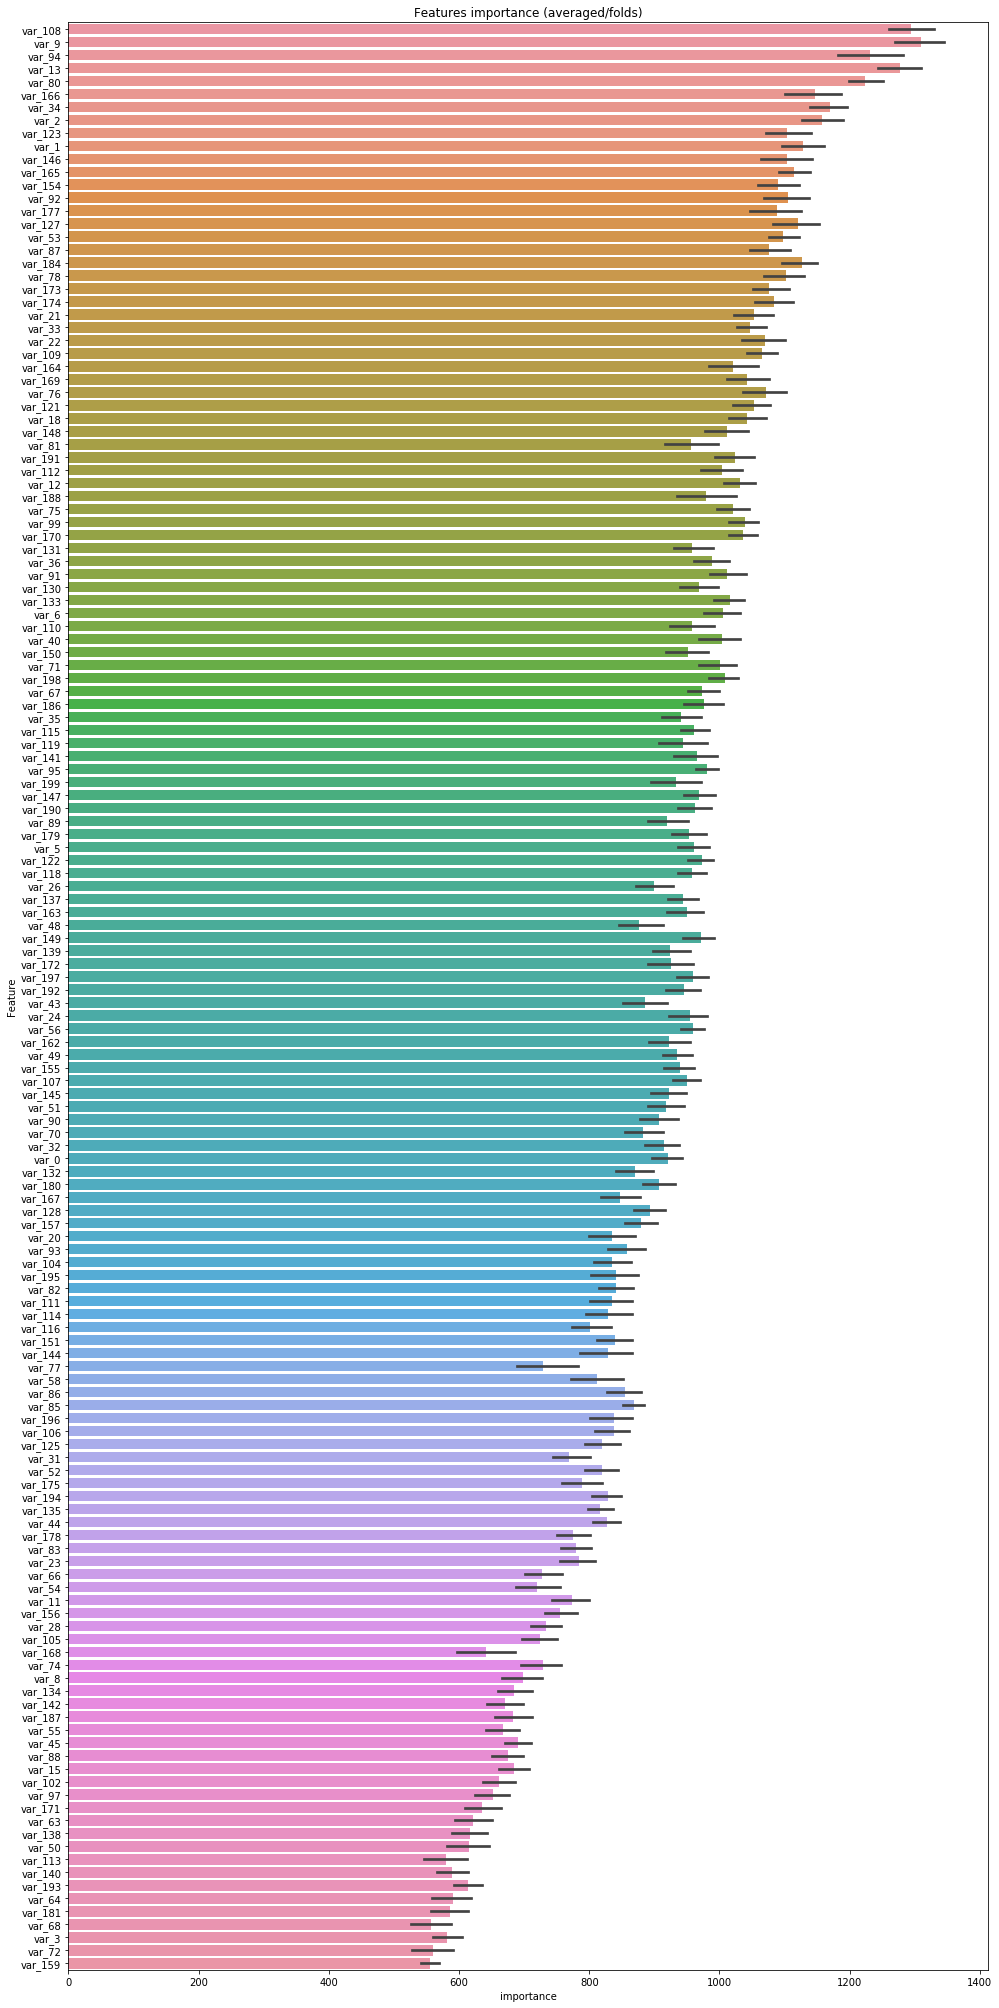

In [11]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

# <a id='6'>Submission</a>  

We submit the solution.

In [12]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

# <a id='7'>References</a>    

[1] https://www.kaggle.com/gpreda/elo-world-high-score-without-blending  
[2] https://www.kaggle.com/chocozzz/santander-lightgbm-baseline-lb-0-897  
[3] https://www.kaggle.com/brandenkmurray/nothing-works

